### ~ Slow Progression

#### Start-Small: 1D Signal (say sine wave) + Noise  - Seperate them using DDPM (ig?) + Do 1D data Metropolis-Hasting and Gibbs Sampling Implementation

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import random
import torch
from torch.utils.data import DataLoader, TensorDataset
import math
import warnings
warnings.filterwarnings('ignore')

10000 (9999,)


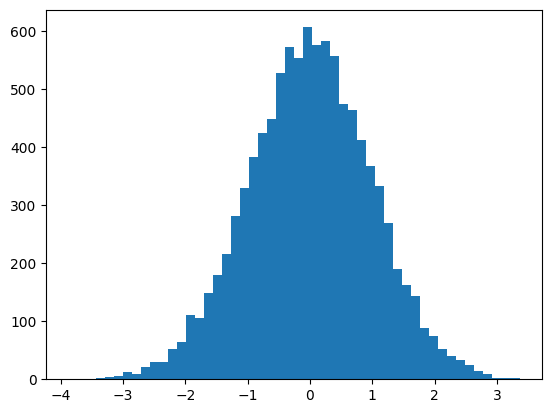

In [25]:
p_x = [np.random.normal(0, 1) for _ in range(10000)]
x = np.arange(1, 10000, 1)

print(len(p_x), x.shape)

plt.hist(p_x, bins=50)
plt.show()

In [ ]:
# Parameters
n_samples = 10000
burn_in = 1000
step_size_mh = 1.0
step_size_hmc = 0.1
n_steps_hmc = 10
initial_x = 0.0

In [18]:
# Target distribution: 0.5*N(-2,1) + 0.5*N(2,1)
def target_distribution(x):
    return 0.5 * norm.pdf(x, loc=-2, scale=1) + 0.3 * norm.pdf(x, loc=2, scale=1) + 0.2 * norm.pdf(x, loc=3.1, scale=2)

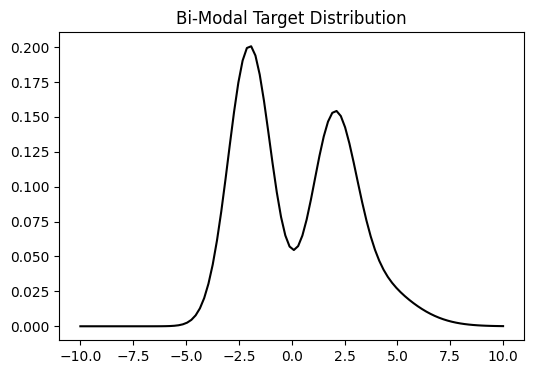

In [19]:
x_lin = np.linspace(-10, 10, 100)
p_x = target_distribution(x_lin)

plt.figure(figsize=(6, 4))
plt.plot(x_lin, p_x, 'k')
plt.title('Bi-Modal Target Distribution')
plt.show()

In [20]:
def log_prob(x):
    return np.log(target_distribution(x))

def grad_log_prob(x):
    w1 = norm.pdf(x, -2, 1)
    w2 = norm.pdf(x, 2, 1)
    total = w1 + w2
    grad_w1 = - (x + 2) * w1
    grad_w2 = - (x - 2) * w2
    grad_total = grad_w1 + grad_w2
    return grad_total / total

##### Metropolis-Hasting


In [ ]:
def metropolis_hastings(n_samples, step_size, initial_x):
    samples = []
    x = initial_x
    accepted = 0
    for _ in range(n_samples):
        x_proposed = np.random.normal(loc=x, scale=step_size)
        log_accept_ratio = log_prob(x_proposed) - log_prob(x) ## metropolis acceptance
        if np.log(np.random.rand()) < log_accept_ratio:
            x = x_proposed
            accepted += 1
        samples.append(x)
    acceptance_rate = accepted / n_samples
    return np.array(samples), acceptance_rate

In [25]:
samples_mh, acc_mh = metropolis_hastings(n_samples, step_size_mh, initial_x)
samples_mh = samples_mh[burn_in:]

Text(0.5, 1.0, 'MH (Acceptance: 0.79)')

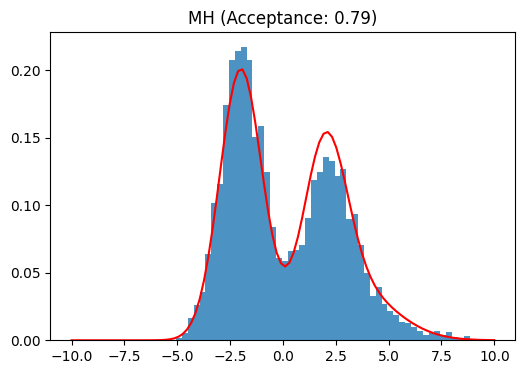

In [26]:
plt.figure(figsize=(6, 4))

plt.hist(samples_mh, bins=50, density=True, alpha=0.8)
plt.plot(x_lin, target_distribution(x_lin), 'r')
plt.title(f'MH (Acceptance: {acc_mh:.2f})')


##### Gibbs Sampling (The Kinda Obvious Sampling Method)
Taking a 3D Gaussian Distribution P(x, y, z)

In [35]:
def gibbs_sampling(n_samples, initial_x):
    samples = []
    x = initial_x
    for _ in range(n_samples):
        p_z0 = 0.5 * norm.pdf(x, -2, 1)
        p_z1 = 0.5 * norm.pdf(x, 2, 1)
        prob_z0 = p_z0 / (p_z0 + p_z1)
        z = np.random.binomial(1, 1 - prob_z0)
        if z == 0:
            x = np.random.normal(-2, 1)
        else:
            x = np.random.normal(2, 1)
        samples.append(x)
    return np.array(samples)

In [36]:
samples_gibbs = gibbs_sampling(n_samples, initial_x)
samples_gibbs = samples_gibbs[burn_in:]

Text(0.5, 1.0, 'Gibbs Sampling')

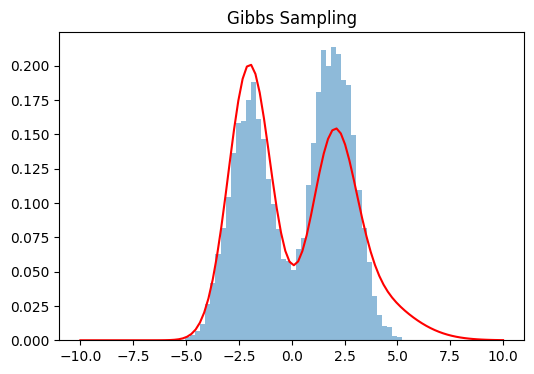

In [37]:
plt.figure(figsize=(6, 4))

plt.hist(samples_gibbs, bins=50, density=True, alpha=0.5)
plt.plot(x_lin, target_distribution(x_lin), 'r')
plt.title('Gibbs Sampling')

In [ ]:
a = 0.5
b = 0.5

Sample means (x, y, z): [-0.01449873 -0.01688274 -0.01093617]
Sample covariance matrix:
 [[1.49779404 1.01146407 0.4947153 ]
 [1.01146407 2.00096009 0.97942131]
 [0.4947153  0.97942131 1.46907395]]


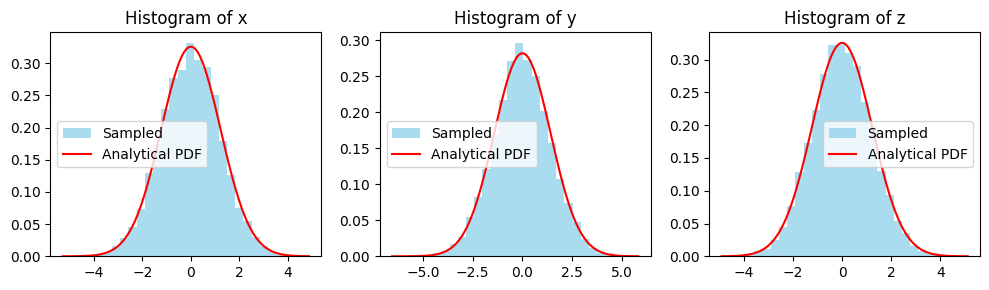

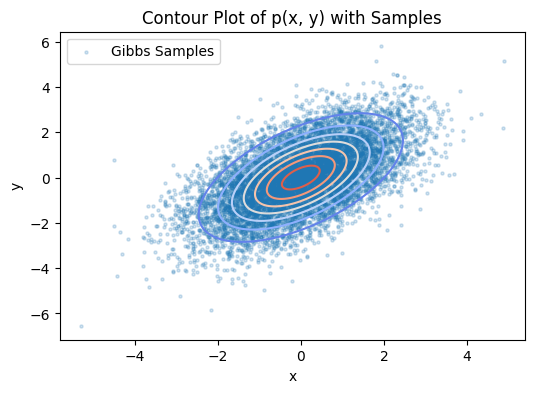

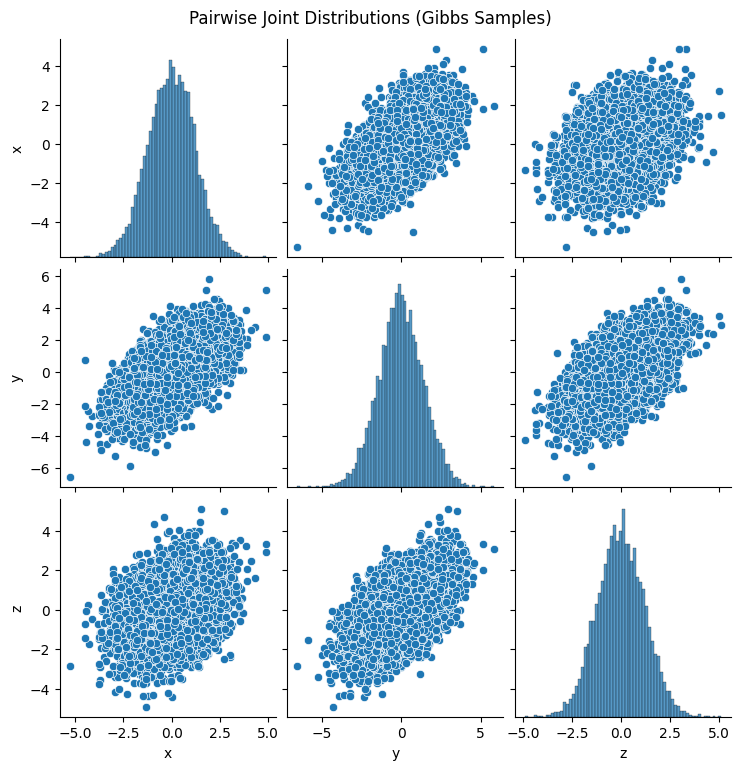

In [ ]:
from scipy.stats import multivariate_normal

# Compute the covariance matrix Σ
precision_matrix = np.array([[1, -a, 0], [-a, 1, -b], [0, -b, 1]])
cov_matrix = np.linalg.inv(precision_matrix)
mean_vector = np.zeros(3)  # Zero mean

# Run Gibbs Sampling
def gibbs_sampler(n_samples, burn_in=1000):
    samples = np.zeros((n_samples, 3))
    x, y, z = 0.0, 0.0, 0.0  # Initial values

    ## We know the form of conditionals before hand 
    for i in range(n_samples + burn_in):
        x = np.random.normal(loc=a * y, scale=1)
        y = np.random.normal(loc=a * x + b * z, scale=1)
        z = np.random.normal(loc=b * y, scale=1)

        if i >= burn_in:
            samples[i - burn_in, :] = [x, y, z]
    return samples

samples = gibbs_sampler(n_samples, burn_in=1000)

sample_means = np.mean(samples, axis=0)
sample_cov = np.cov(samples.T)

print("Sample means (x, y, z):", sample_means)
print("Sample covariance matrix:\n", sample_cov)

# Plot marginal histograms with analytical Gaussian PDFs
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
variable_names = ['x', 'y', 'z']
for i in range(3):
    data_range = np.linspace(samples[:, i].min(), samples[:, i].max(), 100)
    true_pdf = multivariate_normal.pdf(data_range, mean=0, cov=cov_matrix[i, i])
    
    axes[i].hist(samples[:, i], bins=30, density=True, alpha=0.7, color='skyblue', label="Sampled")
    axes[i].plot(data_range, true_pdf, 'r-', label="Analytical PDF")
    axes[i].set_title(f"Histogram of {variable_names[i]}")
    axes[i].legend()

plt.tight_layout()
plt.show()

# Contour plot of theoretical joint distribution p(x, y) {only}
x_range = np.linspace(-3, 3, 100)
y_range = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x_range, y_range)
pos = np.dstack((X, Y))
rv = multivariate_normal(mean=mean_vector[:2], cov=cov_matrix[:2, :2])

plt.figure(figsize=(6, 4))
plt.contour(X, Y, rv.pdf(pos), levels=10, cmap="coolwarm")
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.2, s=5, label="Gibbs Samples")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Contour Plot of p(x, y) with Samples")
plt.legend()
plt.show()

# Pairwise Joint Distributions using Seaborn
sns.pairplot(data=pd.DataFrame({'x': samples[:, 0], "y":samples[:, 1], "z":samples[:, 2]}), diag_kind="hist")
plt.suptitle("Pairwise Joint Distributions (Gibbs Samples)", y=1.02)
plt.show()


##### HMC

Hamiltonian Monte Carlo (HMC) is an MCMC sampling algorithm used to efficiently sample from high-dimensional complex distributions. It introduces auxiliary momentum variables and updates both position and momentum using Leapfrog integration, approximately preserving the system's Hamiltonian (total energy). The Hamiltonian consists of potential energy, related to the negative log probability of the target distribution, and kinetic energy, typically modeled as a Gaussian distribution over momentum. To ensure valid sampling, HMC applies a Metropolis acceptance/rejection step, correcting for numerical errors and guaranteeing convergence to the stationary distribution. Unlike traditional MCMC methods, HMC avoids random walk behavior, leading to faster and more efficient exploration of the probability space.

In [ ]:
def hmc(x0, log_prob, grad_log_prob, step_size, n_steps, mass=1.0):
    p0 = np.random.normal(0, np.sqrt(mass))
    x = x0
    p = p0
    ### LeapFrog Integration
    for _ in range(n_steps):
        ### First half-step update for the momentum
        p += 0.5 * step_size * grad_log_prob(x)
        ### update position (full-step) 
        x += step_size * p / mass
        ### Second half-step update for momentum (symmtric + reversible)
        p += 0.5 * step_size * grad_log_prob(x)
    p = -p
    ## HMC should remain constant along the trajectory (conservation law)
    current_H = -log_prob(x0) + 0.5 * p0**2 / mass
    ## New propoesd state (whether the proposed move should be accepted or rejected based on how well energy was conserved)
    proposed_H = -log_prob(x) + 0.5 * p**2 / mass
    accept = np.log(np.random.rand()) < (current_H - proposed_H) ### proba_ratio (for metropolis acceptance/rejection) 
    return (x, True) if accept else (x0, False)

def hmc_sampling(n_samples, initial_x, step_size, n_steps):
    samples = [initial_x]
    current_x = initial_x
    accepted = 0
    for _ in range(n_samples):
        current_x, accept = hmc(current_x, log_prob, grad_log_prob, step_size, n_steps)
        samples.append(current_x)
        if accept:
            accepted += 1
    acceptance_rate = accepted / n_samples
    return np.array(samples), acceptance_rate


In [41]:
samples_hmc, acc_hmc = hmc_sampling(n_samples, initial_x, step_size_hmc, n_steps_hmc)
samples_hmc = samples_hmc[burn_in:]

Text(0.5, 1.0, 'HMC (Acceptance: 0.90)')

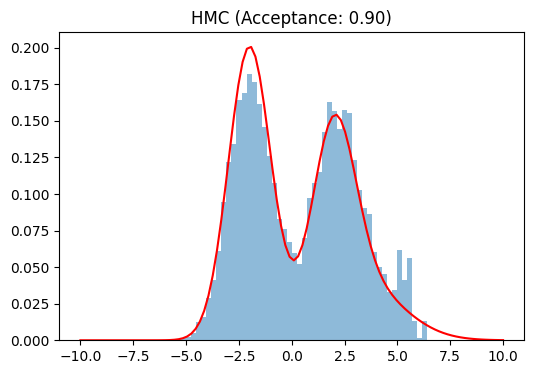

In [43]:
plt.figure(figsize=(6, 4))

plt.hist(samples_hmc, bins=50, density=True, alpha=0.5)
plt.plot(x_lin, target_distribution(x_lin), 'r')
plt.title(f'HMC (Acceptance: {acc_hmc:.2f})')

#### S2 Example Class (2)
Rosenbrock Function Understanding 

In [14]:
!pip install --quiet zeus-mcmc


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import zeus
from mpl_toolkits.mplot3d import Axes3D

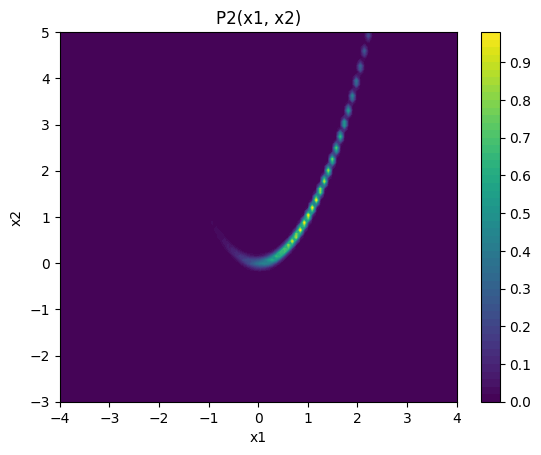

In [13]:
def rosenbrock(x1, x2):
    return 100*(x2 - x1**2)**2 + (1 - x1)**2

x1 = np.linspace(-4, 4, 100)
x2 = np.linspace(-3, 5, 100) ## shifted towards right
X1, X2 = np.meshgrid(x1, x2)
Z = np.exp(-rosenbrock(X1, X2))

plt.contourf(X1, X2, Z, levels=50, cmap='viridis')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('P2(x1, x2)')
plt.colorbar()
plt.show()

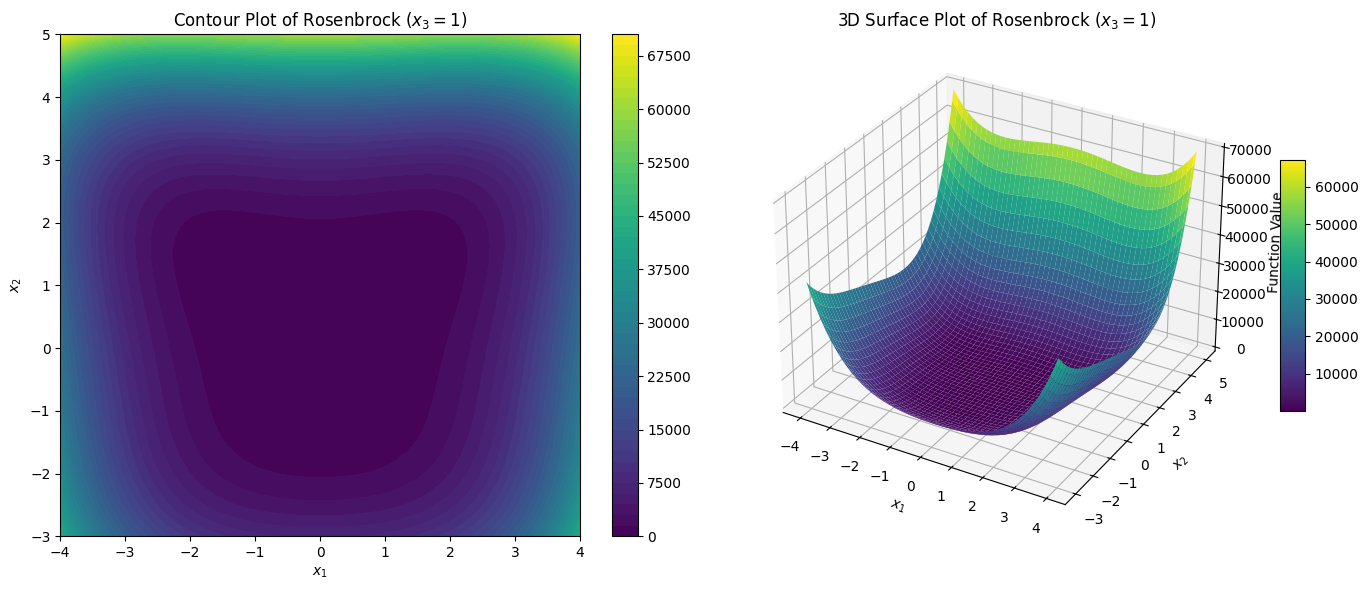

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Rosenbrock function for n=3
def rosenbrock(x1, x2, x3):
    return 100 * (x2 - x1**2)**2 + (1 - x1)**2 + 100 * (x3 - x2**2)**2 + (1 - x2)**2

# Define grid for x1 and x2, fixing x3 = 1
x1 = np.linspace(-4, 4, 100)
x2 = np.linspace(-3, 5, 100)
X1, X2 = np.meshgrid(x1, x2)

# Fix x3 at a constant value (e.g., x3=1)
x3_fixed = 1
Z = rosenbrock(X1, X2, x3_fixed)

# Create figure and subplots
fig = plt.figure(figsize=(14, 6))

# Subplot 1: Contour Plot
ax1 = fig.add_subplot(121)
contour = ax1.contourf(X1, X2, Z, levels=50, cmap='viridis')
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_title('Contour Plot of Rosenbrock ($x_3=1$)')
fig.colorbar(contour, ax=ax1)

# Subplot 2: 3D Surface Plot
ax2 = fig.add_subplot(122, projection='3d')
surf = ax2.plot_surface(X1, X2, Z, cmap='viridis', edgecolor='none')
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_zlabel('Function Value')
ax2.set_title('3D Surface Plot of Rosenbrock ($x_3=1$)')
fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=10)

# Show plots
plt.tight_layout()
plt.show()


In [ ]:
def log_target(x):
    f = sum(100*(x[i+1] - x[i]**2)**2 + (1 - x[i])**2 for i in range(len(x)-1))
    return -f

def metropolis_hastings(n_dims, n_samples, step_size):
    
    samples = np.zeros((n_samples, n_dims))
    current = np.ones(n_dims)  # Start near the minimum | singular points near the minima only 
    current_log_prob = log_target(current)
    
    for i in range(n_samples):
        proposal = current + np.random.normal(0, step_size, n_dims)
        proposal_log_prob = log_target(proposal)
        
        if np.log(np.random.rand()) < (proposal_log_prob - current_log_prob):
            current = proposal
            current_log_prob = proposal_log_prob
        samples[i] = current
    
    return samples

# Parameters
n_dims = 3
n_samples = 10000
step_size = 0.1

samples = n_dims, n_samples, step_size

# Compute E[|x|]
norm = np.linalg.norm(samples[1000:], axis=1)  # Discard burn-in
mean = np.mean(norm)
std_error = np.std(norm) / np.sqrt(len(norm))

print(f"Estimate: {mean:.3f} ± {std_error:.3f}")

Estimate: 0.952 ± 0.006


In [ ]:
# Define log probability (negative Rosenbrock function)
def log_prob(x):
    return -sum(100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2 for i in range(len(x)-1))

# MCMC parameters
n_dims = 3
n_walkers = 10
n_steps = 5000

# Initialize walkers around (1,1,1)
initial = np.random.normal(1, 0.1, (n_walkers, n_dims))

# Set up the sampler
sampler = zeus.EnsembleSampler(n_walkers, n_dims, log_prob)

# Run MCMC
sampler.run_mcmc(initial, n_steps)

# Get samples, discarding burn-in
samples = sampler.get_chain(flat=True, discard=100)

# Compute expected |x|
norm = np.linalg.norm(samples, axis=1)
mean = np.mean(norm)
std_error = np.std(norm) / np.sqrt(len(norm))

# Print results
print(f"Estimate: {mean:.3f} ± {std_error:.3f}")


AttributeError: module 'zeus' has no attribute 'EnsembleSampler'

In [ ]:
corner.corner(samples, labels=['x1', 'x2', 'x3'], truths=[1,1,1])
plt.show()

# Zeus convergence diagnostics (Gelman-Rubin)
gr_stat = zeus.diagnostic.gelman_rubin(sampler.get_chain())
print(f"Gelman-Rubin statistic: {gr_stat}")

# Autocorrelation time
tau = zeus.autocorr.integrated_time(samples)
print(f"Autocorrelation time: {tau}")